# Importing the required library :-

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from wordcloud import WordCloud

# Setting styles for visualization :

In [50]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',300)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

# Loading the dataset :-

In [51]:
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

print("Movies shape:", movies.shape)
print("Credits shape:", credits.shape)

# Here, we use two files from Kaggle(movies + credits)
# These datasets cover 5000+ movies with rich textual and numeric information.

Movies shape: (4803, 20)
Credits shape: (4803, 4)


# Merging Data :-

In [52]:
movies = movies.merge(credits, on='title')
print("Merged shape:", movies.shape)

# We merge them on 'title' to get full metadata for our movie recommendation system
# After merging, each movie entry includes its metadata + cast & crew details.
# It will help us to build a strong foundation for building personalized recommendations.

Merged shape: (4809, 23)


In [53]:
print("\n--- Basic Info ---")
print(movies.info())


--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  s

In [54]:
print("\n--- Missing Values ---")
print(movies.isnull().sum())


--- Missing Values ---
budget                     0
genres                     0
homepage                3096
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                       0
crew                       0
dtype: int64


In [55]:
print("\n--- Duplicates ---")
print(movies.duplicated().sum())

# Dropping duplicate values (if any)
movies.drop_duplicates(inplace=True)


--- Duplicates ---
0


# Keeping only Useful Columns:

In [56]:
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew','vote_average','vote_count','popularity','release_date','runtime','budget','revenue']]

# Selecting only the columns relevent for our system.

# Handling missing values :

In [57]:
movies.dropna(subset=['overview', 'genres', 'keywords', 'cast', 'crew'], inplace=True)
# Missing overviews or keywords can weaken recommendation quality since text-based similarity heavily relies on content-rich fields.

# Converting JSON-like strings into python objects :

In [58]:
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)

# Extract only top 3 cast members :

In [59]:
def top3_cast(obj):
    L = []
    for i in ast.literal_eval(obj)[:3]:
        L.append(i['name'])
    return L

movies['cast'] = movies['cast'].apply(top3_cast)

# Extracting only top 3 cast members because too many names add noise.


# Extract director names for content similarity :

In [60]:
def director(obj):
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            return i['name']
    return np.nan

movies['crew'] = movies['crew'].apply(director)

# Create a "tags" column for recommendation modeling

In [61]:
movies['overview'] = movies['overview'].apply(lambda x: x.split())
movies['genres'] = movies['genres'].apply(lambda x: [i.replace(" ", "") for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x: [i.replace(" ", "") for i in x])
movies['cast'] = movies['cast'].apply(lambda x: [i.replace(" ", "") for i in x])

movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast']
movies['tags'] = movies['tags'].apply(lambda x: " ".join(x))

# Combining all major textual features into a single 'tags' field for NLP vectorization later.
# It blends storyline + genre + theme + cast info into one textual representation, which helps TF-IDF or CountVectorizer find similar movies effectively.

--- Movie Popularity vs Vote Average ---


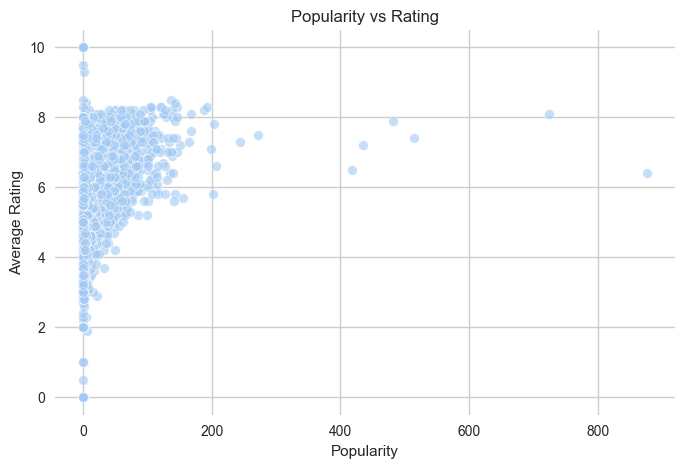

In [62]:
print("--- Movie Popularity vs Vote Average ---")
plt.figure(figsize=(8,5))
sns.scatterplot(data=movies, x='popularity', y='vote_average', alpha=0.6)
plt.title('Popularity vs Rating')
plt.xlabel('Popularity')
plt.ylabel('Average Rating')
plt.show()

# A mild positive trend — popular movies often have higher ratings, but some high-rated films remain underrated in popularity.

--- Distribution of Ratings ---


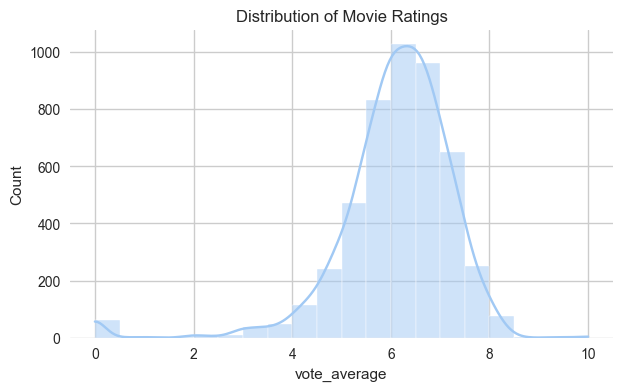

In [63]:
print("--- Distribution of Ratings ---")
plt.figure(figsize=(7,4))
sns.histplot(movies['vote_average'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.show()

# Most movies score between 6–7.5 — showing a central bias.

--- Top Genres ---


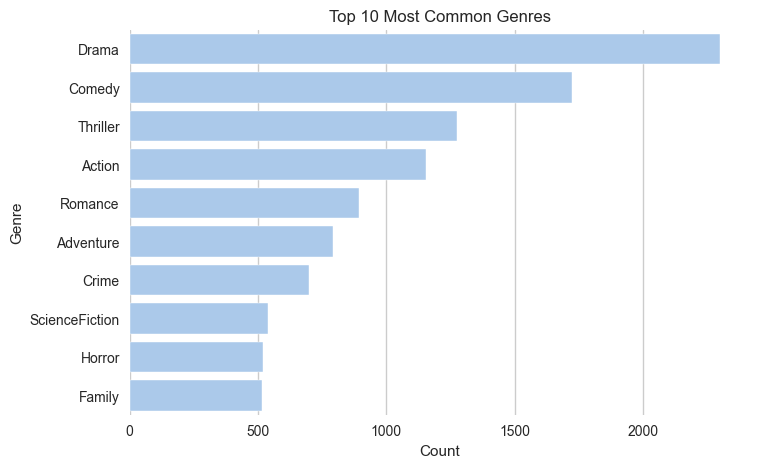

In [64]:
print("--- Top Genres ---")
genre_list = sum(movies['genres'], [])
genre_count = pd.Series(genre_list).value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=genre_count.values, y=genre_count.index)
plt.title("Top 10 Most Common Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

# Drama and Comedy dominate the dataset and it implies that any model should consider balancing these common genres to avoid bias.

--- Most Popular Directors ---


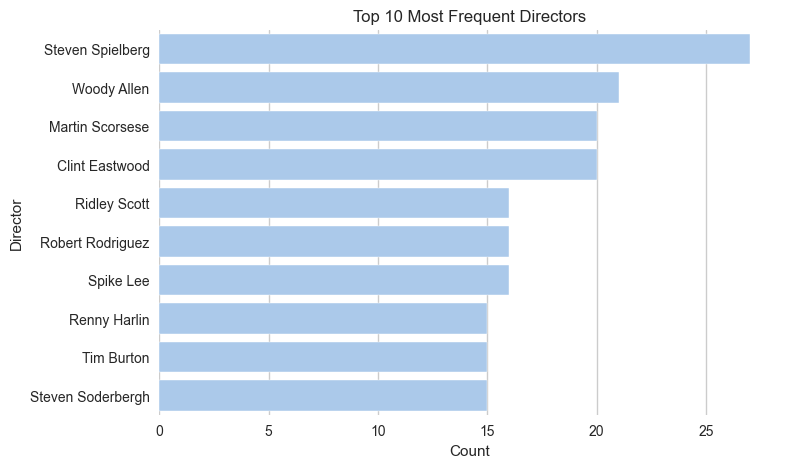

In [65]:
print("--- Most Popular Directors ---")
plt.figure(figsize=(8,5))
sns.barplot(x=movies['crew'].value_counts().head(10).values, y=movies['crew'].value_counts().head(10).index)
plt.title("Top 10 Most Frequent Directors")
plt.xlabel("Count")
plt.ylabel("Director")
plt.show()

# Directors like Steven Spielberg and Woody Allen appear frequently, indicating their strong presence in the dataset that could bring potential bias toward blockbuster themes.

--- WordCloud of Keywords ---


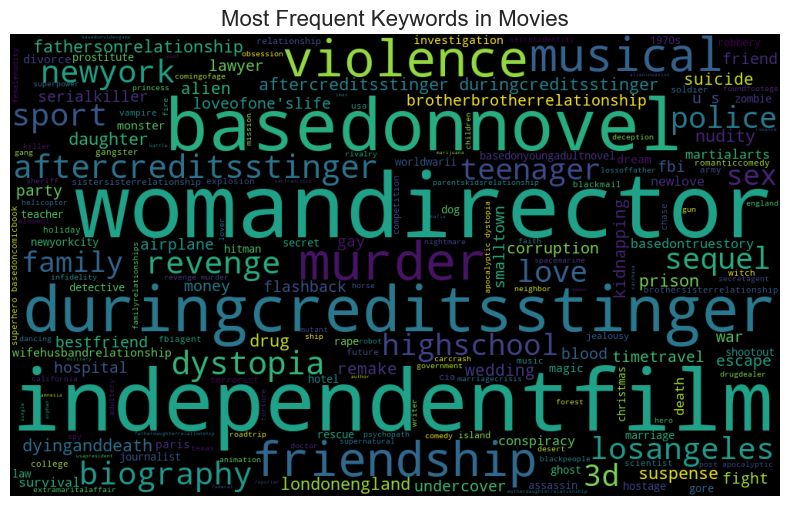

In [66]:
print("--- WordCloud of Keywords ---")
text = " ".join(sum(movies['keywords'], []))
wordcloud = WordCloud(width=1000, height=600, background_color='black').generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most Frequent Keywords in Movies", fontsize=16)
plt.show()

# Frequent words like 'love', 'friendship', 'future', 'revenge' reveal dominant narrative themes and help in understanding user interest trends.

--- Runtime Insights ---


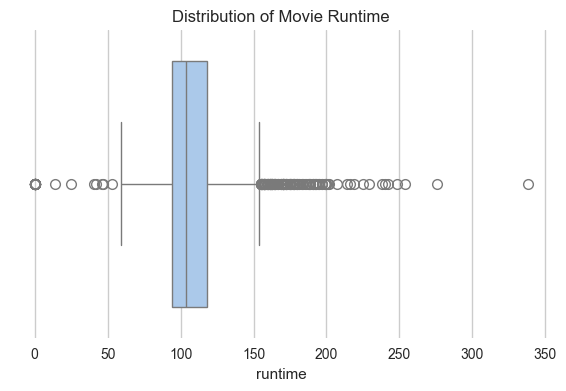

In [67]:
print("--- Runtime Insights ---")
plt.figure(figsize=(7,4))
sns.boxplot(x=movies['runtime'])
plt.title('Distribution of Movie Runtime')
plt.show()

# Most movies range between 90–130 minutes.
# Outliers (very short or very long films)

--- Correlation Heatmap (numerical only) ---


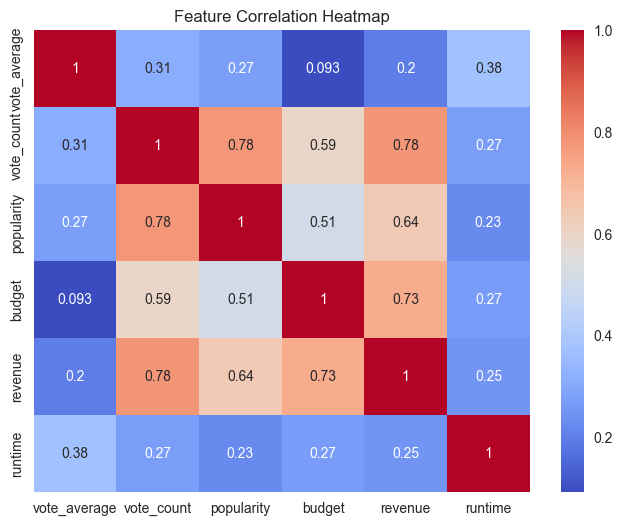

In [68]:
print("--- Correlation Heatmap (numerical only) ---")
num_cols = ['vote_average','vote_count','popularity','budget','revenue','runtime']
plt.figure(figsize=(8,6))
sns.heatmap(movies[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Strong positive correlation between budget and revenue is expected.
# Popularity also correlates with revenue.

--- Yearly Trend of Movies ---


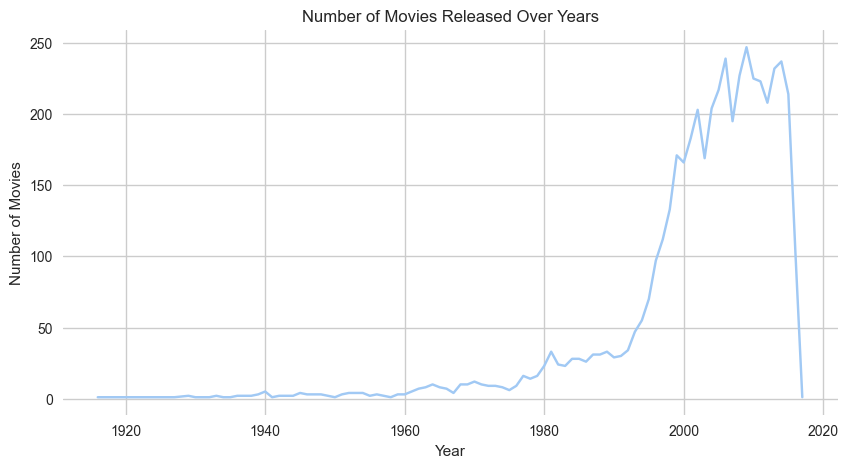

In [69]:
print("--- Yearly Trend of Movies ---")
movies['release_year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year
movies_per_year = movies['release_year'].value_counts().sort_index()
plt.figure(figsize=(10,5))
movies_per_year.plot(kind='line')
plt.title("Number of Movies Released Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()

# Noticeable growth post-2000 that means that modern era contributes most in the data.

In [70]:
# Final Cleaned Data
print("\nSample of processed data:")
print(movies[['title','genres','keywords','cast','crew','tags']].head())


Sample of processed data:
                                      title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                         genres  \
0  [Action, Adventure, Fantasy, ScienceFiction]   
1                  [Adventure, Fantasy, Action]   
2                    [Action, Adventure, Crime]   
3              [Action, Crime, Drama, Thriller]   
4           [Action, Adventure, ScienceFiction]   

                                                                                                                                                                                                                                          keywords  \
0                                   [cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien